In [1]:
import numpy as np
from pathlib import Path
import struct
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import time

In [2]:
dataset_path = Path("./MNIST")
train_img_path = dataset_path/'train-images-idx3-ubyte'
train_lab_path = dataset_path/'train-labels-idx1-ubyte'
test_img_path = dataset_path/'t10k-images-idx3-ubyte'
test_lab_path = dataset_path/'t10k-labels-idx1-ubyte'

In [3]:
with open(train_img_path, "rb") as f:
    struct.unpack(">4i", f.read(16))
    tmp_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28*28)/255
    train_img = tmp_img[:]
with open(test_img_path, "rb") as f:
    struct.unpack(">4i", f.read(16))
    test_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28*28)/255
with open(train_lab_path, "rb") as f:
    struct.unpack(">2i", f.read(8))
    tmp_lab = np.fromfile(f, dtype=np.uint8).reshape(-1, 1)
    train_lab = tmp_lab[:]
with open(test_lab_path, "rb") as f:
    struct.unpack(">2i", f.read(8))
    test_lab = np.fromfile(f, dtype=np.uint8).reshape(-1, 1)
# len(train_img)

In [4]:
# FUNCTION: show_image(index)
def show_image(img, index):
    plt.imshow(img[index].reshape(28, 28), cmap='gray')
    plt.pause(1)
    # print("label: {}".format(label[index]))
    return 0
# show_image(train_img, train_lab, 30)
# len(train_lab[np.where(train_lab == 9)])

In [5]:
train_num = train_img.shape[0]
test_num = test_img.shape[0]
print(train_img.shape)
print(test_img.shape)
print(train_lab.shape)
train_lab

(60000, 784)
(10000, 784)
(60000, 1)


array([[5],
       [0],
       [4],
       ...,
       [5],
       [6],
       [8]], dtype=uint8)

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([    1,    21,    34, ..., 59952, 59972, 59987], dtype=int64))
train set shape: (784, 60000)
train lab shape: (1, 60000)
test set shape: (784, 10000)
test lab shape: (1, 10000)


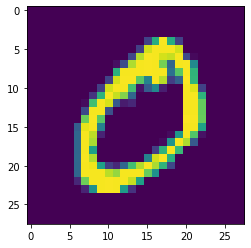

In [6]:
# 将给定num的label改为1
def train_setY(num):
    label = train_lab.copy()
    label[np.where(label != num)] = 10
    label[np.where(label == num)] = 1
    label[np.where(label == 10)] = 0
    return label
def test_setY(num):
    label = test_lab.copy()
    label[np.where(label != num)] = 10
    label[np.where(label == num)] = 1
    label[np.where(label == 10)] = 0
    return label

reg_num = 0
train_X = train_img.copy().T
train_Y = train_setY(reg_num).T
index_regnum = np.where(train_Y==1)
print(index_regnum)
test_X = test_img.copy().T
test_Y = test_setY(reg_num).T
print(f"train set shape: {train_X.shape}")
print(f"train lab shape: {train_Y.shape}")
print(f"test set shape: {test_X.shape}")
print(f"test lab shape: {test_Y.shape}")

# show_image(train_X.T, 1)
hw0 = train_X.T
i = index_regnum[1][0]
np.save(f'handwritten{reg_num}.npy', hw0[i])
plt.imshow(hw0[i].reshape((28,28)))

# # print(train_Y[30])
# print(train_Y.shape)
# # print(np.where(train_Y==1))
# tmp = train_lab.copy().T[:, :limit_train]
# len(tmp[np.where(tmp == reg_num)])

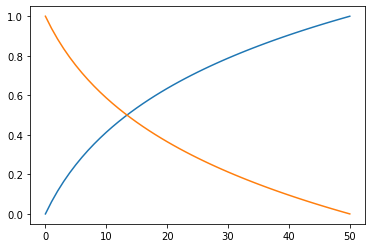

51

In [7]:
# wmax和wmin需要根据使用的电导数据来设定
# parameters = {
#     'a+': 0.03, 'b+': 2.64,
#     'a-': 0.03, 'b-': 2.54,
#     'w+max': 1, 'w+min': 0,
#     'w-max': 1, 'w-min': 0,
# }

parameters = {
    'a+': 0.02, 'b+': 6,
    'a-': 0.02, 'b-': 6,
    'wmax': 1, 'wmin': 0
}

weight_plus_list = [parameters['wmin']]
weight_minus_list = [parameters['wmax']]

def weight_plus(w):
    delta_w = parameters['a+'] * np.exp(-parameters['b+']*(w-parameters['wmin'])
                                             /(parameters['wmax']-parameters['wmin']))
    return delta_w
def weight_minus(w):
    delta_w = parameters['a-'] * np.exp(-parameters['b-']*(parameters['wmax']-w)
                                             /(parameters['wmax']-parameters['wmin']))
    return delta_w
def equation():
    count_num = 0
    while True:
        weight_plus_list.append(weight_plus_list[-1]+weight_plus(weight_plus_list[-1]))
        weight_minus_list.append(weight_minus_list[-1]-weight_minus(weight_minus_list[-1]))
        count_num += 1
        if weight_plus_list[-1] >= 1:
            break
        elif count_num == 50:
            break
        else:
            continue
    
    # return weight_plus_list, weight_minus_list

    # wpl = [0.3*(each - weight_plus_list[0]) / (weight_plus_list[-1]-weight_plus_list[0])-0.2 for each in weight_plus_list]
    # wml = [0.3*(each - weight_minus_list[-1]) / (weight_minus_list[0]-weight_minus_list[-1])-0.2 for each in weight_minus_list]
    
    # wpl = [2*(each - weight_plus_list[0]) / (weight_plus_list[-1]-weight_plus_list[0]) -1 for each in weight_plus_list]
    # wml = [2*(each - weight_minus_list[-1]) / (weight_minus_list[0]-weight_minus_list[-1]) -1 for each in weight_minus_list]
    
    wpl = [(each - weight_plus_list[0]) / (weight_plus_list[-1]-weight_plus_list[0]) for each in weight_plus_list]
    wml = [(each - weight_minus_list[-1]) / (weight_minus_list[0]-weight_minus_list[-1]) for each in weight_minus_list]
    
    return np.array(wpl), np.array(wml)
GP, GD = equation()
# print(GP)
# print(GD)

# GP_tmp = np.loadtxt("ryx-GP.txt")
# GD_tmp = np.loadtxt("ryx-GD.txt")

# GP = [0.3*(each-min(GP_tmp))/(max(GP_tmp)-min(GP_tmp))-0.2 for each in GP_tmp]
# GD = [0.3*(each-min(GD_tmp))/(max(GD_tmp)-min(GD_tmp))-0.2 for each in GD_tmp]

# GP = [(each-min(GP_tmp))/(max(GP_tmp)-min(GP_tmp)) for each in GP_tmp]
# GD = [(each-min(GD_tmp))/(max(GD_tmp)-min(GD_tmp)) for each in GD_tmp]

plt.plot(GP)
plt.plot(GD)
plt.show()
# np.savetxt(f"GP {parameters['b+']}.txt", GP)
# np.savetxt(f"GD {parameters['b-']}.txt", GD)
len(GP)

In [8]:
def findGP_num(data, find_array=GP):
    diff = abs(data - find_array)
    index = np.where(diff == np.min(diff))[0][0]
    # print(index)
    return find_array[index]

def findGD_num(data, find_array=GD):
    diff = abs(data - find_array)
    index = np.where(diff == np.min(diff))[0][0]
    return find_array[index]


# 可以利用G1-G2来实现-1~1的取值范围
def each_change(matrix_old, gradw, learning_rate):
    matrix_new = matrix_old.copy()
    for i in range(matrix_old.shape[0]):
        if gradw[i] < 0:
            matrix_new[i] = matrix_old[i] + learning_rate*weight_plus(matrix_old[i])
            # matrix_new[i] = findGP_num(matrix_old[i])
        elif gradw[i] > 0:
            # matrix_new[i] = findGD_num(matrix_old[i])
            matrix_new[i] = matrix_old[i] - learning_rate*weight_minus(matrix_old[i])
        else:
            continue
    return matrix_new
# tmp = np.zeros((10, 1))
# each_change(tmp, [0]*len(tmp))

In [9]:
# 激活函数
def sigmoid(z):
    s = 1.0 / (1.0 + np.exp(-1.0*z))
    return s

# 参数初始化
def initialize_with_zeros(dim):
    ### 权重w = G['+'] - G['-']
    np.random.seed(6)
    G = {'+':np.random.random((dim, 1)), '-':np.random.random((dim, 1))}  
    b = 0
    
    assert(G['+'].shape == (dim, 1))
    # assert(G['-'].shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return G, b

# 向前传播
def propagate(G, b, X, Y):
    m = X.shape[1]
    dG = {'+':0, '-':0}

    A = sigmoid(np.dot((G['+']-G['-']).T, X) + b)
    cost = -(1.0/m) * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))
    
    dG['+'] = (1.0/m) * np.dot(X, (A-Y).T)
    dG['-'] = -(1.0/m) * np.dot(X, (A-Y).T)

    db = (1.0/m) * np.sum(A-Y)

    Y_prediction = np.zeros((1, m))
    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    accu = 100 - np.mean(np.abs(Y_prediction-Y)) * 100
    
    assert(dG['+'].shape == G['+'].shape)
    assert(dG['-'].shape == G['-'].shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    grads = {
        "dG": dG,
        "db": db
    }
    
    return grads, cost, accu

# 参数优化
def optimize(G, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    accus = []
    for i in range(num_iterations):
        grads, cost, accu = propagate(G, b, X, Y)
        dG = grads["dG"]
        db = grads["db"]

        b = b - learning_rate * db
        
        #######
        G['+'] = each_change(G['+'], dG['+'], learning_rate)
        G['-'] = each_change(G['-'], dG['-'], learning_rate)
        # 这里或许可以写成原数据归一化后的wmax和wmin
        # 可以利用G1-G2来实现-1~1的取值范围
        G['+'][np.where(G['+']>1)] = 1
        G['+'][np.where(G['+']<0)] = 0
        G['-'][np.where(G['-']>1)] = 1
        G['-'][np.where(G['-']<0)] = 0
        #######

        if i%10 == 0:
            costs.append(cost)
            accus.append(accu)
            
#             print(f"w max:{np.max(w)}, w min:{np.min(w)}")
#             print(f"dw max:{np.max(dw)}, dw min:{np.min(dw)}")
#         if i == num_iterations/2 or i == num_iterations-1:
#             w_tmp = w.copy()
#             plt.imshow(w_tmp.reshape((28,28)))
#             plt.pause(1)
        if print_cost and i%(num_iterations//10) == 0:
            print("    Cost after iterations %i: %f" %(i, cost), end=' ')
            print(f"accu: {accus[-1]}%")
        
    params = {
        "G": G,
        "b": b
    }
    grads = {
        "dG": dG,
        "db": db
    }

    # return params, grads, costs
    return params, grads, accus

# 模型预测
def predict(G, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    G['+'] = G['+'].reshape(X.shape[0], 1)
    G['-'] = G['-'].reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot((G['+']-G['-']).T, X) + b)
    
    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost=False):
    G, b = initialize_with_zeros(X_train.shape[0])
    # parameters, grads, costs= optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    parameters, grads, accus= optimize(G, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    G = parameters["G"]
    b = parameters["b"]
    
    Y_prediction_test = predict(G, b, X_test)
    Y_prediction_train = predict(G, b, X_train)
    
    print("train accuracy: {}%".format(100-np.mean(np.abs(Y_prediction_train-Y_train))*100))
    print("test accuracy: {}%".format(100-np.mean(np.abs(Y_prediction_test-Y_test))*100))
    
    d = {
        "accus": accus,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train": Y_prediction_train,
        "G": G,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations
    }
    
    return d

In [11]:
# start = time.time()
print(f"Number {reg_num} Recognition with ")
print(f"    a+={parameters['a+']}, b+={parameters['b+']}, a-={parameters['a-']}, b-={parameters['b-']}: ")
d = model(train_X, train_Y, test_X, test_Y, num_iterations=1000, learning_rate=1, print_cost=True)
# stop = time.time()
# print(f"{stop-start}s")

Number 0 Recognition with 
    a+=0.02, b+=6, a-=0.02, b-=6: 
    Cost after iterations 0: 2.823549 accu: 19.326666666666668%
    Cost after iterations 100: 0.049078 accu: 98.715%
    Cost after iterations 200: 0.032806 accu: 99.14%
    Cost after iterations 300: 0.029436 accu: 99.21666666666667%
    Cost after iterations 400: 0.027787 accu: 99.23666666666666%
    Cost after iterations 500: 0.027115 accu: 99.27%
    Cost after iterations 600: 0.026532 accu: 99.265%
    Cost after iterations 700: 0.026055 accu: 99.28166666666667%
    Cost after iterations 800: 0.025751 accu: 99.27666666666667%
    Cost after iterations 900: 0.025594 accu: 99.27166666666666%
train accuracy: 99.27833333333334%
test accuracy: 99.2%


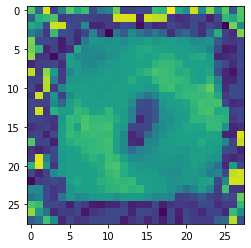

In [12]:
G = d["G"].copy()
w = G['+']-G['-']

# w[np.where(w<-1)] = -1

plt.imshow(w.reshape((28,28)))
plt.pause(0.1)
# np.savetxt(f"w{reg_num}.txt", w.reshape((28,28)))
# print(max(w))
# print(min(w))

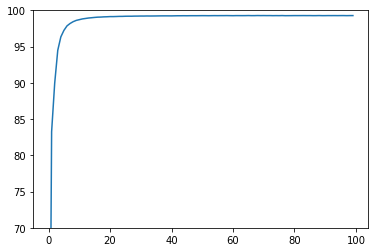

99.285%


In [14]:
accus = d["accus"].copy()
plt.plot(accus)
plt.ylim(70, 100)
plt.show()
np.savetxt(f"accu{reg_num}_a={parameters['a+']}_b={parameters['b+']}.txt", accus)
# np.savetxt(f"accu{reg_num}_ideal.txt", accus)
print(f"{max(accus)}%")

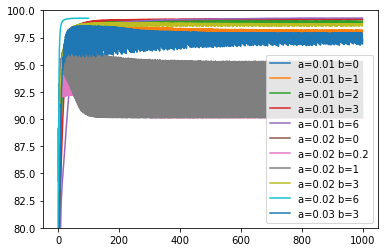

In [16]:
reg_num = 0
# a = 0.01
accus0_001_0 = np.loadtxt(f"accu{reg_num}_a=0.01_b=0.txt")
accus0_001_1 = np.loadtxt(f"accu{reg_num}_a=0.01_b=1.txt")
accus0_001_2 = np.loadtxt(f"accu{reg_num}_a=0.01_b=2.txt")
accus0_001_3 = np.loadtxt(f"accu{reg_num}_a=0.01_b=3.txt")
accus0_001_6 = np.loadtxt(f"accu{reg_num}_a=0.01_b=6.txt")
accus0_001_9 = np.loadtxt(f"accu{reg_num}_a=0.01_b=9.txt")
accus0_001_12 = np.loadtxt(f"accu{reg_num}_a=0.01_b=12.txt")
accus0_001_15 = np.loadtxt(f"accu{reg_num}_a=0.01_b=15.txt")

# a = 0.02
accus0_002_0 = np.loadtxt(f"accu{reg_num}_a=0.02_b=0.txt")
accus0_002_02 = np.loadtxt(f"accu{reg_num}_a=0.02_b=0.2.txt")
accus0_002_1 = np.loadtxt(f"accu{reg_num}_a=0.02_b=1.txt")
accus0_002_3 = np.loadtxt(f"accu{reg_num}_a=0.02_b=3.txt")
accus0_002_6 = np.loadtxt(f"accu{reg_num}_a=0.02_b=6.txt")

# a = 0.03
accus0_003_3 = np.loadtxt(f"accu{reg_num}_a=0.03_b=3.txt")

# a = 0.01
plt.plot(accus0_001_0,      label='a=0.01 b=0')
plt.plot(accus0_001_1,      label='a=0.01 b=1')
plt.plot(accus0_001_2,      label='a=0.01 b=2')
plt.plot(accus0_001_3,      label='a=0.01 b=3')
plt.plot(accus0_001_6,      label='a=0.01 b=6')
# plt.plot(accus0_001_9,      label='a=0.01 b=9')
# plt.plot(accus0_001_12,     label='a=0.01 b=12')
# plt.plot(accus0_001_15,     label='a=0.01 b=15')

# a = 0.02
plt.plot(accus0_002_0,      label='a=0.02 b=0')
plt.plot(accus0_002_02,     label='a=0.02 b=0.2')
plt.plot(accus0_002_1,      label='a=0.02 b=1')
plt.plot(accus0_002_3,      label='a=0.02 b=3')
plt.plot(accus0_002_6,      label='a=0.02 b=6')

# a = 0.03
plt.plot(accus0_003_3,      label='a=0.03 b=3')

plt.ylim(80, 100)
plt.legend(loc=4)
plt.show()

# print('accus0 a=0 b=0:  ',  max(accus0_0))
# print('accus0 a=0 b=1:  ',  max(accus0_1))
# print('accus0 a=0 b=2:  ',  max(accus0_2))
# print('accus0 a=0 b=3:  ',  max(accus0_3))
# print('accus0 a=0 b=6:  ',  max(accus0_6))
# print('accus0 a=0 b=9:  ',  max(accus0_9))
# print('accus0 a=0 b=12: ',  max(accus0_12))
# print('accus0 a=0 b=15: ',  max(accus0_15))

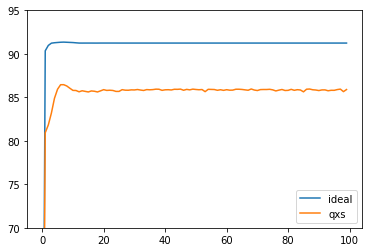

In [11]:
ideal = np.loadtxt('accu9_ideal.txt')
qxs = np.loadtxt('accu9_qxs.txt')

plt.plot(ideal,     label='ideal')
plt.plot(qxs,       label='qxs')
plt.ylim(70, 95)
plt.legend(loc=4)
plt.show()